# 变量解释

Pregnancies: 怀孕次数

Glucose：葡萄糖  正常为3.92-6.16$mmol/L$

BloodPressure;血压（$mm Hg$）正常范围90-140

SkinThickness：皮脂厚度($mm$)超过20即为肥胖

Insulin：2小时血清胰岛素含量（$mu/ml$）正常人为4.03-23.46

BMI： 体重指数($kg/m^2$) BMI大于28即为肥胖

DiabetesPedigreeFunction： 遗传指数

Age; 年龄(岁）

Outcome: 标签 1：患病 0： 不患病

In [1]:
import pandas as pd
pd.set_option('precision', 3)   # 设置精度
import numpy as np
import time    # 记算运行时间
from sklearn import metrics
import matplotlib.pyplot  as plt
from sklearn.model_selection import train_test_split
from matplotlib import font_manager
plt.rcParams['font.sans-serif'] = ['SimHei']   # 中文显示问题
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
from sklearn.metrics import accuracy_score  # 准确率
import warnings

warnings.filterwarnings("ignore")

In [2]:
diabetes = pd.read_csv("D:/deep-learning/datasets/diabetes.csv")
diabetes

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


# 标签频数观察

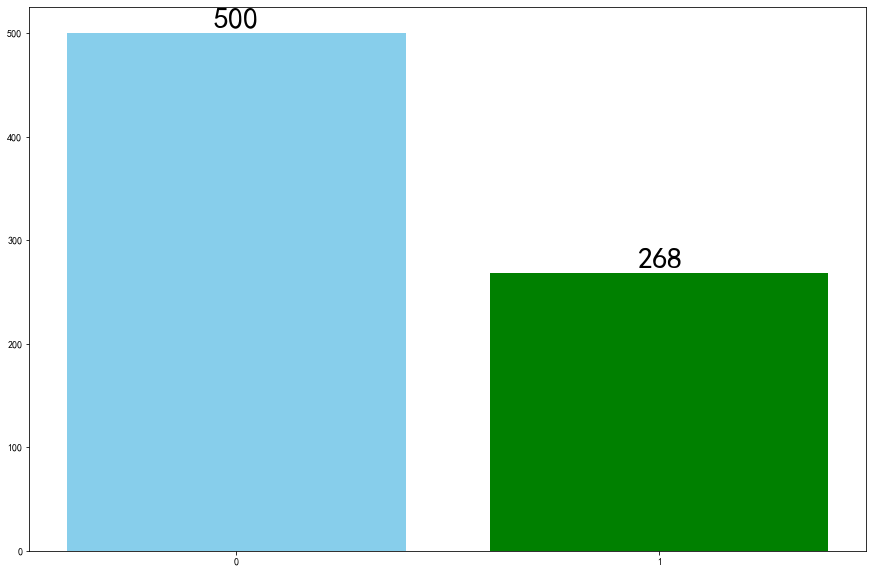

In [3]:
plt.figure(figsize = (15, 10))
label_counts = diabetes['Outcome'].value_counts()   # 统计标签频数
plt.bar(label_counts.keys(), label_counts.values, color = ['skyblue', 'g'])
plt.xticks(label_counts.keys())
for a, b in zip(label_counts.keys(), label_counts.values):
    plt.text(a, b, '%.0f'%b, ha = 'center', va = 'bottom', fontsize =30)
plt.show()

# 处理数据
## 异常值处理

In [4]:
diabetes.describe()    # 查看数据均值、标准差、最大、最小值、分位数

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000,768.000,768.000,768.000,768.000,768.000,768.000,768.000,768.000
mean,3.845,120.895,69.105,20.536,79.799,31.993,0.472,33.241,0.349
std,3.370,31.973,19.356,15.952,115.244,7.884,0.331,11.760,0.477
min,0.000,0.000,0.000,0.000,0.000,0.000,0.078,21.000,0.000
25%,1.000,99.000,62.000,0.000,0.000,27.300,0.244,24.000,0.000
50%,3.000,117.000,72.000,23.000,30.500,32.000,0.372,29.000,0.000
75%,6.000,140.250,80.000,32.000,127.250,36.600,0.626,41.000,1.000
max,17.000,199.000,122.000,99.000,846.000,67.100,2.420,81.000,1.000


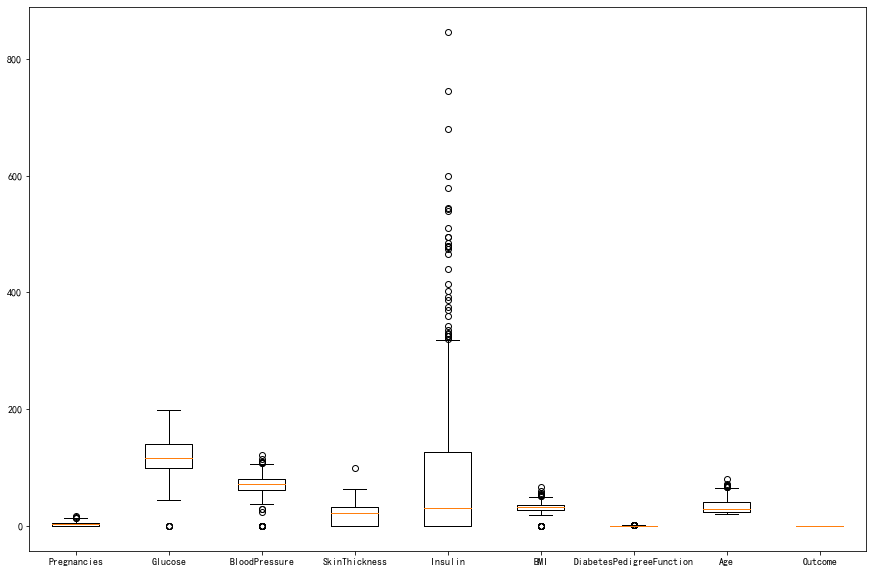

In [5]:
'''通过箱线图观察'''
plt.figure(figsize = (15, 10))
plt.boxplot(diabetes, labels = diabetes.columns)
plt.show()

3$\sigma$原则适用于服从正态分布的数据

箱线图异常值定义为小于$Q_1 - 1.5IQR$或大于$Q_3 + 1.5IQR$  $IQR = Q_3 - Q_1$

而考虑数据信息的丢失，只删除一些明显异常的值：Insulin = 846、skinthickness = 99、 BMI = 67

而怀孕次数、血压、年龄的取值是在合理范围之内，不做异常值处理。

In [6]:
'''处理异常值'''
diabetes = diabetes.loc[~diabetes['Insulin'].isin([846])]
diabetes = diabetes.loc[~diabetes['SkinThickness'].isin([99])]
diabetes = diabetes.loc[~diabetes['BMI'].isin([67.1])]
diabetes

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


# 缺失值处理

2小时血清胰岛素含量、葡萄糖含量、血压、皮脂厚度为0十分反常，可以认为是存在缺失值的。

以同类平均数进行填充

In [7]:
diabetes_0 = diabetes.loc[diabetes['Outcome'] == 0]
diabetes_1 = diabetes.loc[diabetes['Outcome'] == 1]
zero_mean = diabetes_0.mean()
one_mean = diabetes_1.mean()

In [8]:
for attribute in ['Insulin', 'Glucose', 'BloodPressure', 'SkinThickness', 'BMI']:
    for i in diabetes.index:
        if diabetes[attribute][i] == 0:
            if diabetes['Outcome'][i] == 0:
                diabetes[attribute][i] = zero_mean[attribute]
            else:
                diabetes[attribute][i] = one_mean[attribute] 
diabetes

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,97,33.6,0.627,50,1
1,1,85,66,29,68,26.6,0.351,31,0
2,8,183,64,21,97,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,68,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,21,97,30.1,0.349,47,1


# 确认处理后数据

In [9]:
diabetes.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,765.000,765.000,765.000,765.000,765.000,765.000,765.000,765.000,765.000
mean,3.856,121.489,72.216,26.265,117.186,32.394,0.472,33.179,0.346
std,3.371,30.299,12.058,9.425,90.227,6.778,0.332,11.697,0.476
min,0.000,44.000,24.000,7.000,14.000,18.200,0.078,21.000,0.000
25%,1.000,99.000,64.000,19.000,68.000,27.500,0.243,24.000,0.000
50%,3.000,117.000,72.000,23.000,97.000,32.000,0.371,29.000,0.000
75%,6.000,140.000,80.000,32.000,126.000,36.600,0.627,41.000,1.000
max,17.000,199.000,122.000,63.000,744.000,59.400,2.420,81.000,1.000


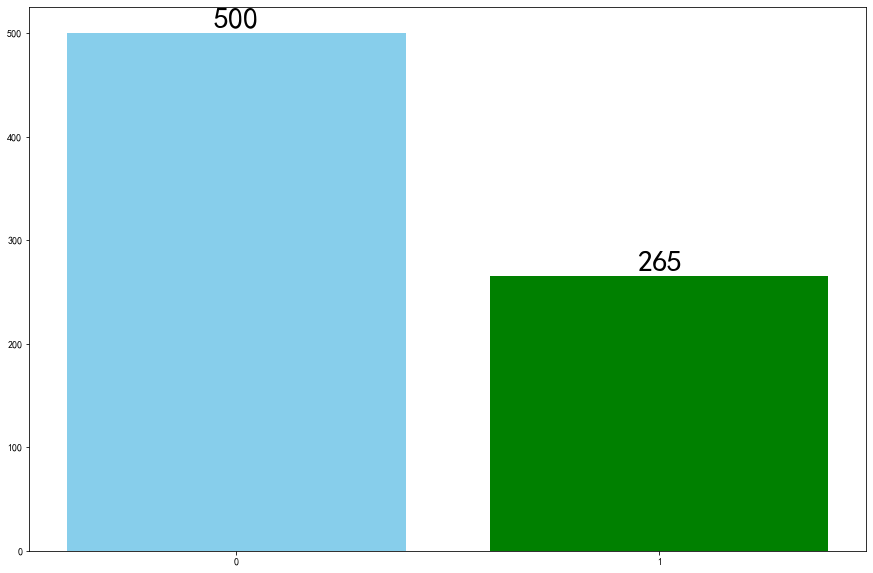

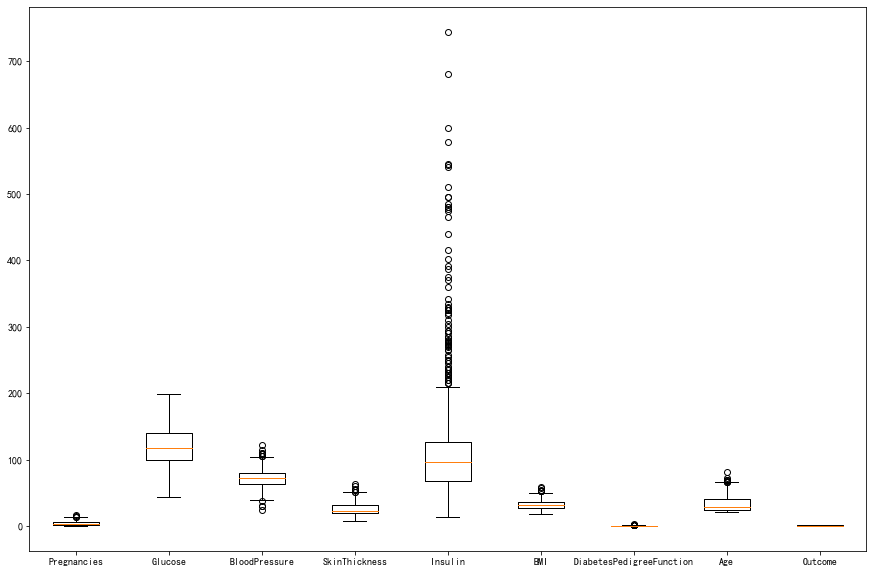

In [10]:
plt.figure(figsize = (15, 10))
label_counts = diabetes['Outcome'].value_counts()   # 统计标签频数
plt.bar(label_counts.keys(), label_counts.values, color = ['skyblue', 'g'])
plt.xticks(label_counts.keys())
for a, b in zip(label_counts.keys(), label_counts.values):
    plt.text(a, b, '%.0f'%b, ha = 'center', va = 'bottom', fontsize =30)
plt.show()
plt.figure(figsize = (15, 10))
plt.boxplot(diabetes, labels = diabetes.columns)
plt.show()

# 归一化处理
通过观察箱线图，发现各个特征之间存在明显的量纲差别，学生采用的是归一化处理，有别于标准化，能够在消除量纲影响时有效保留原数据分布特点

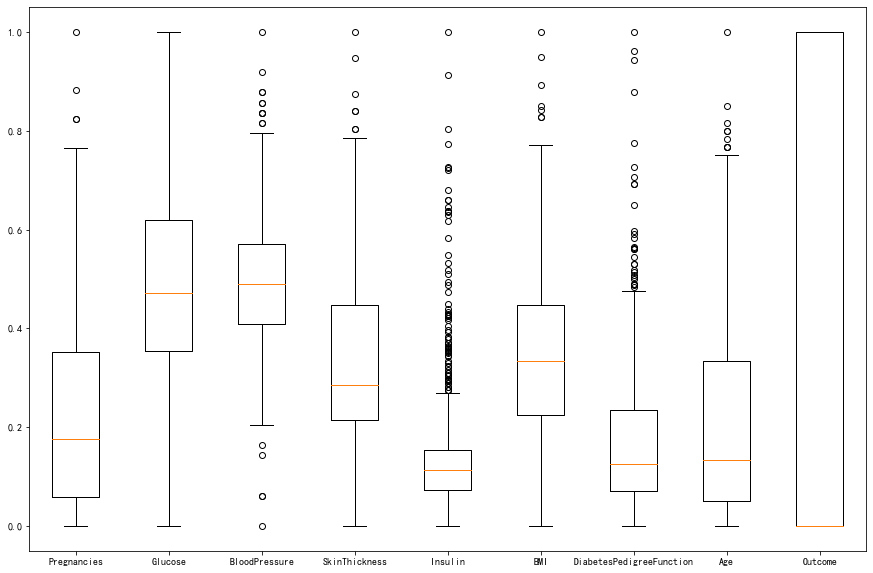

In [11]:
def MIN_MAX(X, MAX, MIN):
    X = (X - MIN) / (MAX - MIN)
    return X

for attribute in diabetes.columns:
    MAX = diabetes[attribute].max()
    MIN = diabetes[attribute].min()
    diabetes[attribute] = MIN_MAX(diabetes[attribute], MAX, MIN)
plt.figure(figsize = (15, 10))
plt.boxplot(diabetes, labels = diabetes.columns)
plt.show()

In [12]:
X = diabetes.iloc[:,:-1]
Y = diabetes.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 123457)

In [13]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# KNN

In [14]:
from sklearn.neighbors import KNeighborsClassifier
start = time.time()
avg_scores = []
all_scores = []
test_scores = []
parameter_value = list(range(1, 21))
for n_neighbors in parameter_value:
    KNN = KNeighborsClassifier(n_neighbors = n_neighbors)
    scores = cross_val_score(KNN, X_train, y_train, scoring = 'accuracy')
    KNN.fit(X_train, y_train)
    y_pre = KNN.predict(X_test)
    KNN_accuracy = accuracy_score(y_test,y_pre)
    avg_scores.append(np.mean(scores))
    all_scores.append(scores)
    test_scores.append(KNN_accuracy)
end = time.time()
print(f'KNN交叉验证调参运行时间为：{end - start:.4f}')

KNN交叉验证调参运行时间为：1.4421


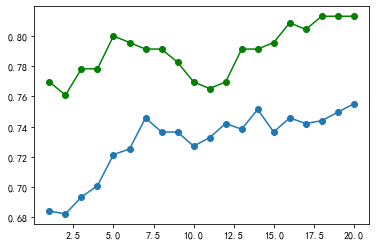

In [15]:
plt.plot(parameter_value, avg_scores, '-o')
plt.plot(parameter_value, test_scores, '-o', color = 'g')
plt.show()

In [16]:
# k = 6
KNN = KNeighborsClassifier(n_neighbors = 6)
KNN.fit(X_train, y_train)
y_pre = KNN.predict(X_test)
KNN_accuracy = accuracy_score(y_test,y_pre)
print(f'测试集准确率为：{KNN_accuracy:.4f}')
print(classification_report(y_test, y_pre))

测试集准确率为：0.7957
              precision    recall  f1-score   support

         0.0       0.80      0.92      0.86       153
         1.0       0.77      0.56      0.65        77

    accuracy                           0.80       230
   macro avg       0.79      0.74      0.75       230
weighted avg       0.79      0.80      0.79       230



准确来说，并不能画出在测试集上的正确率曲线，否则会导致测试集参与模型的训练，发生过拟合。
此处做个参考。k可取10

# 随机森林

In [17]:
from sklearn.ensemble import RandomForestClassifier
start_RT = time.time()
parameter_space = {
    'max_features': [2, 10, 'auto'],
    'n_estimators': [100, 200],
    'criterion': ['gini', 'entropy'],
    'min_samples_leaf': [2, 4, 6]
}
clf = RandomForestClassifier(random_state = 3)
grid_rt = GridSearchCV(clf, parameter_space)
grid_rt.fit(X_train, y_train)
end_RT = time.time()
print(f'随机森林网格搜索调整参数运行时间：{end_RT - start_RT:.4f}')

随机森林网格搜索调整参数运行时间：32.9938


In [18]:
print(f'泛化误差估计为：{grid_rt.best_score_}')
print(grid_rt.best_estimator_)

泛化误差估计为：0.8822429906542055
RandomForestClassifier(max_features=2, min_samples_leaf=2, random_state=3)


In [19]:
y_pre = grid_rt.predict(X_test)
RT_accuracy = accuracy_score(y_test, y_pre)
print(f'测试集准确率为：{RT_accuracy:.4f}')
print(classification_report(y_test, y_pre))

测试集准确率为：0.9000
              precision    recall  f1-score   support

         0.0       0.93      0.92      0.92       153
         1.0       0.84      0.87      0.85        77

    accuracy                           0.90       230
   macro avg       0.89      0.89      0.89       230
weighted avg       0.90      0.90      0.90       230



# catboost
梯度提升决策树（GBDT）的改进版，可以更好处理类别数据，并且实现类别之间的组合。

In [29]:
import catboost as cb
# start_cb = time.time()
# cv_parameter = {'iterations': [100, 200],
#                'learning_rate': [0.1, 0.2]
#                }
# parameter_space = {
#     'depth': 3,
#     'loss_function': 'Logloss',
#     'leaf_estimation_method': 'Newton',
#     'random_state': 12
# }
# cb_model = cb.CatBoostClassifier(parameter_space)
# grid_cb = GridSearchCV(cb_model, cv_parameter)
# grid_cb.fit(X_train, y_train)
# end_cb = time.time()
print(f'CATBOOST网格搜索调部分参数运行时间为：{end_cb - start_cb:.4f}')

CATBOOST网格搜索调部分参数运行时间为：9.9783


In [21]:
print(f'泛化误差估计为：{grid_cb.best_score_}')
print(grid_cb.best_estimator_)

泛化误差估计为：0.8785046728971964


In [22]:
y_pre = grid_cb.predict(X_test)
cb_accuracy = accuracy_score(y_test, y_pre)
print(f'测试集准确率;{cb_accuracy:.4f}')
print(classification_report(y_test, y_pre))

测试集准确率;0.8913
              precision    recall  f1-score   support

         0.0       0.93      0.91      0.92       153
         1.0       0.82      0.86      0.84        77

    accuracy                           0.89       230
   macro avg       0.88      0.88      0.88       230
weighted avg       0.89      0.89      0.89       230



# SVM

In [23]:
from sklearn.svm import SVC
start_svr = time.time()
parameters = {'kernel':('linear', 'rbf'), 'C': [0.1, 1, 10]}
svr = SVC()
grid_svc = GridSearchCV(svr, parameters)
grid_svc.fit(X_train, y_train)
end_svr = time.time()
print(f'SVM网格搜索调参的运行时间为：{end_svr - start_svr : .4f}')

SVM网格搜索调参的运行时间为： 0.3191


In [24]:
print(f'泛化误差估计为：{grid_svc.best_score_}')
print(grid_svc.best_estimator_)

泛化误差估计为：0.7514018691588785
SVC(C=1, kernel='linear')


In [25]:
y_pre = grid_svc.predict(X_test)
svc_accuracy = accuracy_score(y_test, y_pre)
print(f'测试集准确率：{svc_accuracy:.4f}')
print(classification_report(y_test, y_pre))

测试集准确率：0.8000
              precision    recall  f1-score   support

         0.0       0.81      0.92      0.86       153
         1.0       0.78      0.56      0.65        77

    accuracy                           0.80       230
   macro avg       0.79      0.74      0.76       230
weighted avg       0.80      0.80      0.79       230



# voting

In [30]:
from mlxtend.classifier import EnsembleVoteClassifier

# start_vote = time.time()
# KNN = KNeighborsClassifier(n_neighbors = 6)
# clf = RandomForestClassifier(max_features = 2, min_samples_leaf = 2, random_state = 3)
# svr = SVC(C=10, kernel='linear', probability = True)
# eclf = EnsembleVoteClassifier(clfs = [grid_cb, clf, svr], voting = 'soft')
# params_weights = {
#     'weights': [[1, 1, 1],
#                [1, 2, 1]]
# }

# grid_eclf = GridSearchCV(eclf, params_weights)
# grid_eclf.fit(X_train, y_train)
# end_vote = time.time()
print(f'voting法运行时间为： {end_vote - start_vote : .4f}')

voting法运行时间为：  105.6568


In [27]:
print(f'泛化误差估计为：{grid_eclf.best_score_}')
print(grid_eclf.best_estimator_)

泛化误差估计为：0.8728971962616822
EnsembleVoteClassifier(clfs=[GridSearchCV(estimator=<catboost.core.CatBoostClassifier object at 0x0000024503114DF0>,
                                          param_grid={'iterations': [100, 200],
                                                      'learning_rate': [0.1,
                                                                        0.2]}),
                             RandomForestClassifier(max_features=2,
                                                    min_samples_leaf=2,
                                                    random_state=3),
                             SVC(C=10, kernel='linear', probability=True)],
                       voting='soft', weights=[1, 2, 1])


In [28]:
y_pre = grid_eclf.predict(X_test)
es_accuracy = accuracy_score(y_test, y_pre)
print(f'测试集准确率:{es_accuracy:.4f}')
print(classification_report(y_test, y_pre))

测试集准确率:0.8913
              precision    recall  f1-score   support

         0.0       0.92      0.92      0.92       153
         1.0       0.83      0.84      0.84        77

    accuracy                           0.89       230
   macro avg       0.88      0.88      0.88       230
weighted avg       0.89      0.89      0.89       230

